In [8]:
import numpy as np
from matplotlib import pyplot as plt
import pickle as pkl

## The plotting handler

In [3]:
def plot_with_errorband(ax,trial_data,indices = None,label=''):
    mu = np.mean(trial_data,axis=0)
    std = np.std(trial_data,axis=0)

    if indices is None:
        indices = range(len(mu))
    
    ax.plot(indices,np.array(mu),label=label)
    ax.fill_between(indices,mu+std,mu-std,alpha=0.2)

In [4]:
def cost(Q,hist):
    n_trial = hist.shape[0]
    timesteps = hist.shape[1]
    Q_cost = [hist[i,j].T.dot(Q).dot(hist[i,j]) for i in range(n_trial) for j in range(timesteps)]

    Q_cost = np.array(Q_cost).reshape(n_trial,timesteps)
    return Q_cost

# Total LQR Cost vs $\bar{\eta}$

In [5]:
etas = [0.1,0.5,1.0,1.5,2.0]
control_alg = ['SafeLearning','Benchmark']

In [6]:
data = {}
  
costs = {alg:[] for alg in control_alg}

A_errors = {alg:[] for alg in control_alg}
B_errors = {alg:[] for alg in control_alg}

for alg in control_alg:

    for eta in etas:
        with open('{}_eta_{}.pkl'.format(alg,eta),'rb') as f:
            data[eta] = pkl.load(f)

    with open('Parameters.pkl','rb') as f:
        data['Parameters'] = pkl.load(f)

    Q = data['Parameters']['Q']
    R = data['Parameters']['R']
    A = data['Parameters']['A']
    B = data['Parameters']['B']


    mean_cost = []
    std_cost = []

    for eta in etas:
        x_hist = np.array([d['x'] for d in data[eta]])
        u_hist = np.array([d['u'] for d in data[eta]])

        c = np.sum(cost(Q,x_hist),axis=-1)+np.sum(cost(R,u_hist[:,:,np.newaxis,np.newaxis]),axis=-1)
        costs[alg].append(c)
        
    costs[alg] = np.array(costs[alg])




Text(0, 0.5, 'LQR Cost')

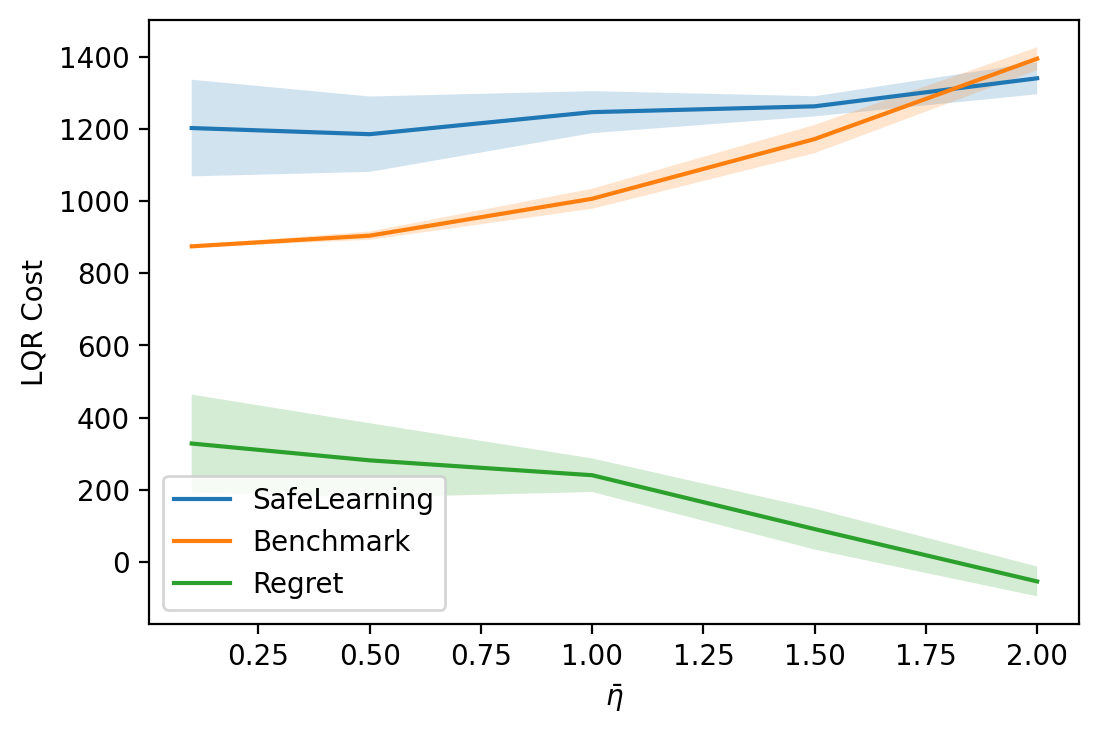

In [7]:

plt.figure(dpi=200)
plot_with_errorband(plt.gca(),costs['SafeLearning'].T,etas,'SafeLearning')
plot_with_errorband(plt.gca(),costs['Benchmark'].T,etas,'Benchmark')
plot_with_errorband(plt.gca(),(costs['SafeLearning']-costs['Benchmark']).T,etas,'Regret')


plt.legend()
plt.xlabel(r'$\bar{\eta}}$')
plt.ylabel('LQR Cost')

In [24]:
data = {}

with open('Parameters.pkl','rb') as f:
    data['Parameters'] = pkl.load(f)

A = data['Parameters']['A']
B = data['Parameters']['B']  

A_errors = []
B_errors = []

for eta in etas:
    with open('SafeLearning_eta_{}.pkl'.format(eta),'rb') as f:
        data[eta] = pkl.load(f)


for eta in etas:

    thetas = [d['theta'] for d in data[eta]]

    As = np.array([[t[0] for t in theta_hist] for theta_hist in thetas])
    Bs = np.array([[t[1] for t in theta_hist] for theta_hist in thetas])

    # As.shape = (# trials, # refits, x_dim, x_dim)
    # Bs.shape = (# trials, # refits, x_dim, u_dim)
    
    A_diff = np.linalg.norm(As[:,-1,:,:]-A,np.inf,axis=(-1,-2))
    B_diff = np.linalg.norm(Bs[:,-1,:,:]-B,np.inf,axis=(-1,-2))
    
    
    A_errors.append(A_diff)
    B_errors.append(B_diff)
    

A_errors = np.array(A_errors)
B_errors = np.array(B_errors)


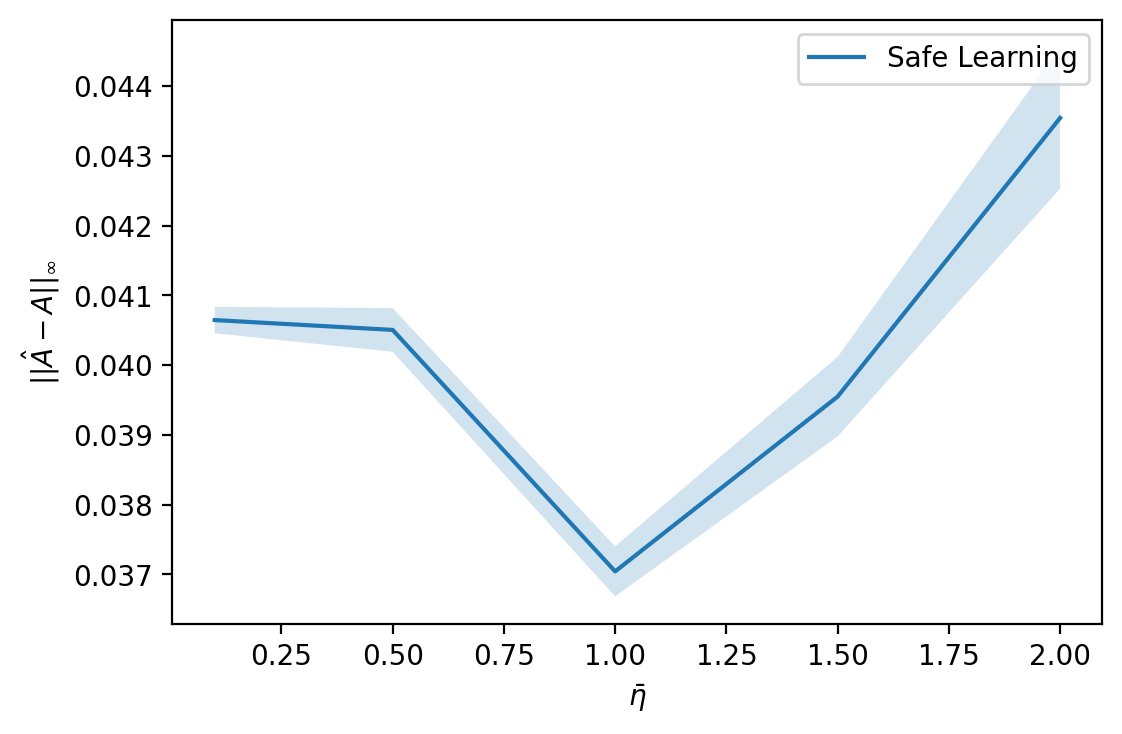

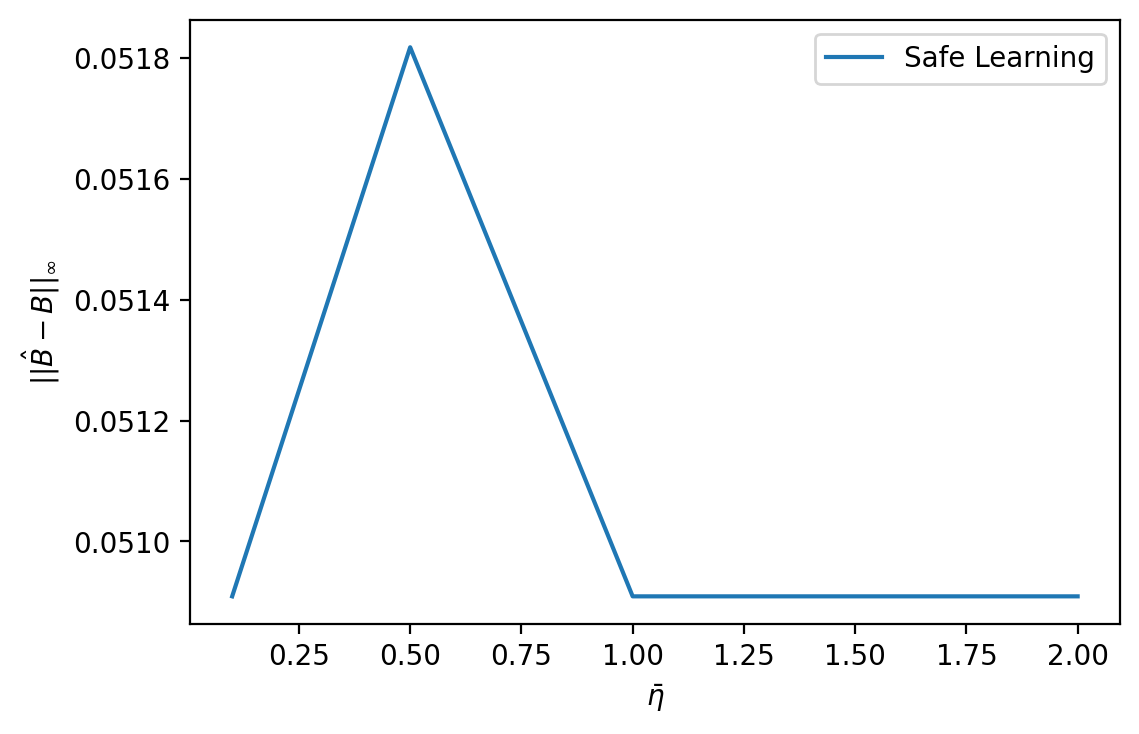

In [28]:

plt.figure(dpi=200)
plot_with_errorband(plt.gca(),A_errors.T,etas,'Safe Learning')

plt.legend()
plt.xlabel(r'$\bar{\eta}}$')
plt.ylabel(r'$||\hat{A}-A||_{\infty}$')
plt.show()


plt.figure(dpi=200)
plot_with_errorband(plt.gca(),B_errors.T,etas,'Safe Learning')

plt.legend()
plt.xlabel(r'$\bar{\eta}}$')
plt.ylabel(r'$||\hat{B}-B||_{\infty}$')
plt.show()

## LQR Stage Regret vs $t$

In [7]:
Q = data['Parameters']['Q']
R = data['Parameters']['R']

control_cost = {}
for alg in control_alg:
    
    x_hist = np.array([np.array(d['x']) for d in data[alg]])
    u_hist = np.array([np.array(d['u']) for d in data[alg]])
    control_cost[alg] = cost(Q,x_hist) + cost(R,u_hist[:,:,np.newaxis,np.newaxis])


KeyError: 'SafeLearning'

In [ ]:
plt.figure(dpi=200)
ax = plt.gca()
for key,item in control_cost.items():
    plot_with_errorband(ax,item,key)

plot_with_errorband(ax,control_cost['SafeLearning']-control_cost['Benchmark'],'Stage Regret')
ax.set_ylabel('Cost')
ax.set_xlabel(r'$t$')
ax.legend()
plt.show()

## Estimation error vs t.

In [ ]:
thetas = [d['theta'] for d in data['SafeLearning']]
A = data['Parameters']['A']
B = data['Parameters']['B']

In [ ]:
As = np.array([[t[0] for t in theta_hist] for theta_hist in thetas])
Bs = np.array([[t[1] for t in theta_hist] for theta_hist in thetas])

# As.shape = (# trials, # refits, x_dim, x_dim)
# Bs.shape = (# trials, # refits, x_dim, u_dim)

A_diff = np.linalg.norm(As-A,np.inf,axis=(-1,-2))
B_diff = np.linalg.norm(Bs-B,np.inf,axis=(-1,-2))